# Problem Set 5

As usual, you are highly encouraged to *start this problem set early!*  My best guess (no guarantees!) is that Part 1 will be conceptually easy but perhaps time consuming.  Parts 2 and 3 are medium difficult, but there are plenty of opportunities to get confused with python data structures, so if you're going to get stuck, get stuck (and unstuck) early!

Note that the two extra credit problems have the potential to be quite challenging and time consuming. Make sure to do everything else in the problem set before you tackle the extra credit.

To get started, download the files "reviews.csv" and "movies.dat" from Canvas.

For this assignment, the following libraries may be useful:

* [numpy](http://docs.scipy.org/doc/numpy-dev/user/index.html), for arrays
* [scikit-learn](http://scikit-learn.org/stable/), for machine learning
* [pandas](http://pandas.pydata.org/), for data frames
* [matplotlib](http://matplotlib.org/), for plotting

In particular, I suggest you familiarize yourself with the following aspects of these libraries, which are not required but which might make your life easier:

* `DataFrame` and other basic [data structures](http://pandas.pydata.org/pandas-docs/stable/dsintro.html) in pandas
* [`groupby`](http://pandas.pydata.org/pandas-docs/stable/groupby.html), `unique`,  and other simple aggregation functions
* [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) for working with text in sklearn.
* [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) for Naive Bayes
* Simple tools for [Cross-Validation](http://scikit-learn.org/stable/modules/cross_validation.html) in sklearn

Make sure they load properly with the following code block:

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#hint: Consult the scikit-learn documentation to
#      learn about what these classes do do
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

## Introduction to the assignment

In this assignment, you'll be analyzing movie reviews in an attempt to determine whether movies are good or bad.  I've downloaded a large number of movie reviews from the [Rotten Tomatoes](http://www.rottentomatoes.com) website, which are available in the file "reviews.csv" on Canvas.  I've also put a file "movies.dat" on Canvas that contains metadata for ~65,000 different movies

If you've never seen Rotten Tomatoes before, go spend a few minutes familiarizing yourself with the website.  It's a meta-review website that aggregates movie reviews from a large number of critics.  Here's what the page for this year's [Oscar winner](https://www.rottentomatoes.com/m/the_shape_of_water_2017) looks like.  Note in particular the section on "Critic Reviews" at the bottom -- that's the content that has been scraped and put in the reviews.csv file.  Also note that each movie is given a quantitative score on the Tomatometer which is used to classify the movie as either Fresh (good) or Rotten (bad).

Your mission is to develop a classifier to determine whether a movie is Fresh or Rotten based on the contents of the reviews given to the movie.  As usual, we'll start out with some exploratory data analysis.

---

## Part 1: Descriptive analysis

Before beginning the "real" work, dig into the data a bit do see what you're dealing with.  Begin by loading the datasets and dropping rows that have missing data:

In [3]:
reviews = pd.read_csv('reviews.csv')
movies = pd.read_csv("movies.dat", delimiter='\t')

reviews = reviews[~reviews.quote.isnull()]
reviews = reviews[reviews.fresh != 'none']
reviews = reviews[reviews.quote.str.len() > 0]
reviews = reviews.reset_index(drop=True)

### 1.1: Basic features of the dataset

Answer the following questions by having your python code directly print the answers:

* How many unique reviews (quotes) are in the `reviews` dataset?
* How many unique reviewers (critics) are in the `reviews` dataset?
* How many unique movies are in the `reviews` dataset?
* How many unique movies are in the *`movies`* dataset?
* How many different publications have reviews in the `reviews` dataset?


In [7]:
# enter your code below
print("Number of unique reviews (quotes): {} ".format(len(reviews['quote'].unique())))
print("Number of unique reviews (critics): {} ".format(len(reviews['critic'].unique())))
print("Number of unique movies in reviews dataset: {} ".format(len(reviews['title'].unique())))
print("Number of unique movies in movies dataset based on unique title: {} ".format(len(movies['title'].unique())))
print("Number of unique movies in movies dataset based on ID: {} ".format(len(movies['imdbID'].unique())))
print("Number of different publications: {} ".format(len(reviews['publication'].unique())))

Number of unique reviews (quotes): 12814 
Number of unique reviews (critics): 541 
Number of unique movies in reviews dataset: 1720 
Number of unique movies in movies dataset based on unique title: 9405 
Number of unique movies in movies dataset based on ID: 9423 
Number of different publications: 64 


### 1.2 Number of reviews per reviewer

Using the `reviews` dataset, create a histogram showing the distribution of the number of reviews per reviewer.  Create the bin width (x-axis) to be 1 unit wide, and the range of the axis to be from 0 to 30.  Scale the y-axis to show the logarithm of (count of) the number of reviewers.  Label your axes and make your histogram look professional.

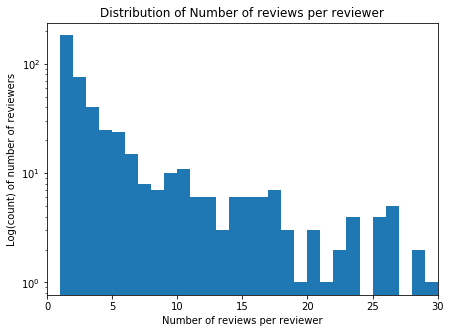

In [8]:
critic_count= reviews['critic'].value_counts()

fig, ax = plt.subplots(figsize=(7,5))

bins = np.arange(0,np.max(critic_count)+1)
ax.hist(critic_count, bins=bins, log=True)
ax.set_xlim(0,30)
ax.set_xlabel('Number of reviews per reviewer')
ax.set_ylabel('Log(count) of number of reviewers')
ax.set_title("Distribution of Number of reviews per reviewer");

### 1.3 Zoom in on a few reviewers
Find the 30 critics with the most reviews, and list their names in a table along with (a) the name of the publication they work for, (b) the date of their first review, and (c) the date of their last review

*hint: use the groupby function to do this quickly*

In [9]:
req = reviews.copy()
req = req.sort_values('review_date').groupby('critic').agg({'fresh':['count'],'publication': ['first'], 'review_date': ['first', 'last']})
req.columns = req.columns.droplevel(1)
req = req.reset_index()
req.columns = ['Critic','ReviewsCount','Publication','FirstReviewDate','LastReviewDate']
req = req.sort_values('ReviewsCount',ascending=False).head(30).reset_index(drop=True)
req

,Critic,ReviewsCount,Publication,FirstReviewDate,LastReviewDate
0,Roger Ebert,1150,Chicago Sun-Times,2000-01-01 00:00:00,2013-06-11 00:00:00
1,James Berardinelli,833,ReelViews,1800-01-01 00:00:00,2012-02-07 00:00:00
2,Janet Maslin,526,New York Times,2000-01-01 00:00:00,2010-09-07 00:00:00
3,Variety Staff,449,Variety,2001-02-13 00:00:00,2012-08-15 00:00:00
4,Jonathan Rosenbaum,420,Chicago Reader,1988-07-11 00:00:00,2013-10-22 00:00:00
5,Desson Thomson,373,Washington Post,2000-01-01 00:00:00,2012-10-08 00:00:00
6,Geoff Andrew,361,Time Out,2005-08-11 00:00:00,2012-04-05 00:00:00
7,Dave Kehr,360,Chicago Reader,2000-01-01 00:00:00,2013-11-20 00:00:00
8,Kenneth Turan,282,Los Angeles Times,2000-01-01 00:00:00,2013-10-05 00:00:00
9,Mick LaSalle,280,San Francisco Chronicle,2000-01-01 00:00:00,2009-11-25 00:00:00


### 1.4 Ratings over time

Using the `movies` dataset, create a plot that shows how the average rating per movie (rtAllCriticsRating) has evolved over time.  Do this by creating a scatterplot where the x-axis is the year in which the movie was released and the y-axis is rtAllCriticsRating.  Drop movies with 0 or unknown values to avoid biasing your results.  Then, create a scatterplot that has one <year,rating> point for each remaining movie, and pick an appropriate size/color/transparency for these points to ensure that the graph looks professional.  In other words, do not simply use the default settings, as this will produce a dense mess of dots that will be hard to interpret.  Finally, overlay on this scatterplot a line graph in orange showing how the average movie rating (the average of rtAllCriticsRating across all movies in a year) has changed over time.  Do you notice a trend?  What do you think it means?

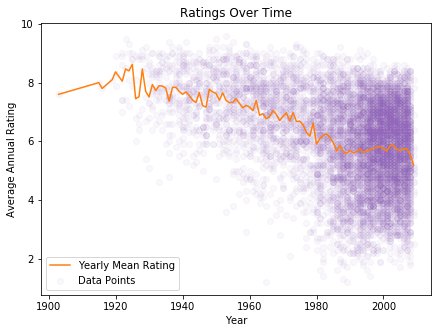

In [10]:
req_data = movies[(movies.rtAllCriticsRating != '\\N') & (movies.rtAllCriticsRating != "0")]
req_data['rtAllCriticsRating'] = req_data['rtAllCriticsRating'].astype(float)
meanRating_year = req_data.groupby('year')['rtAllCriticsRating'].mean()

fig, ax = plt.subplots(figsize=(7,5))

ax.scatter(req_data['year'], req_data['rtAllCriticsRating'], alpha=0.05, c='C4', label='Data Points')
ax.plot(meanRating_year.index, meanRating_year, c='C1', label='Yearly Mean Rating')
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Average Annual Rating')
ax.set_title('Ratings Over Time');

There seems to be an overall decreasing trend in the average annual rating of the movies. It somehow implies that over the period of time, either the quality of the movies being made have degraded or the critics have become more stickler.   

---

## Part 2: Naive Bayes

Now it gets fun!  You are going to use a [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) to build a prediction model for whether a review is fresh or rotten, depending on the text of the review. Review the assigned readings on Canvas, as well as the relevant lecture notes before embarking on this journey.

### Using CountVectorizer

One thing that may help you in the following problems is the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) object in Scikit-learn.  This will help you convert your raw text fields into "bag of words" vectors, i.e. a data structure that tells you how many times a particular word appears in a blurb.  Here's a simple example, make sure you understand what's going on!

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['machine learning rocks', 'machine learning rules', 'rocks rocks rules']
print("Original text is\n", '\n'.join(text))
print()
vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("Transformed text vector is \n", x)
print()
# `get_feature_names` tracks which word is associated with each column of the transformed x
print("Words for each feature:")
print(vectorizer.get_feature_names())

Original text is
 machine learning rocks
machine learning rules
rocks rocks rules

Transformed text vector is 
 [[1 1 1 0]
 [1 1 0 1]
 [0 0 2 1]]

Words for each feature:
['learning', 'machine', 'rocks', 'rules']


### 2.1 Create your X input and Y output

Using the `reviews` dataframe, compute a pair of numerical X, Y arrays where:
    
 * X is a `(nreview, nwords)` array. Each row corresponds to a bag-of-words representation for a single review. This will be the *input* to your model.
 * Y is a `nreview`-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired *output* from your model.
 
Make sure to remove items with no review text

In [12]:
"""
Function
--------
make_xy

Build a bag-of-words training set for the review data

Parameters
-----------
reviews : Pandas DataFrame
    The review data from above
    
vectorizer : CountVectorizer object (optional)
    A CountVectorizer object to use. If None,
    then create and fit a new CountVectorizer.
    Otherwise, re-fit the provided CountVectorizer
    using the reviews data
    
Returns
-------
X : numpy array (dims: nreview, nwords)
    Bag-of-words representation for each review.
Y : numpy array (dims: nreview)
    1/0 array. 1 = fresh review, 0 = rotten review

Examples
--------
X, Y = make_xy(reviews)
"""
def make_xy(reviews, vectorizer=None):
    #Your code here 
    
    Y = (reviews['fresh'] == 'fresh').astype(int)
    
    quotes = reviews['quote']
    
    if vectorizer == None:
        vectorizer = CountVectorizer(min_df=0)
        
    vectorizer.fit(quotes)
    X = vectorizer.transform(quotes)
    X = X.toarray()
    
    return X, Y

In [13]:
X, Y = make_xy(reviews)
print(np.shape(X))
print(np.shape(Y))

(13419, 20875)
(13419,)


### 2.2 Test-Train split

Next, randomly split the data into two groups: a training set (80%) and a validation set (20%).  You can do this manually, as you did in the prior problem set.  Or, use [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) to do this auto-magically.  See [this guide](http://scikit-learn.org/stable/modules/cross_validation.html) for a simple example of how `train_test_split` works.

In [28]:
train, test = train_test_split(reviews, test_size=0.2, random_state=123)

### 2.3 Naive Bayes with `MultinomialNB`
Use the training set to train a Naive Bayes classifier using the [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
 object.  Report the accuracy of this model on both the training and testing data.  What do you observe?  Interpret these results!

*Hint: This shouldn't take more than 5-10 lines of code to accomplish*



In [29]:
X, Y = make_xy(reviews)

# Initialize and fit the model
fitted_model = MultinomialNB()
fitted_model.fit(X[train.index], Y[train.index])

# Predicting
prediction_train = fitted_model.predict(X[train.index])
prediction_test = fitted_model.predict(X[test.index])

# Accuracy Computation
train_accuracy = sum(prediction_train == Y[train.index])/len(prediction_train)
test_accuracy = sum(prediction_test == Y[test.index])/len(prediction_test)

print('Train accuracy = {:.4f}'.format(train_accuracy))
print('Test  accuracy = {:.4f}'.format(test_accuracy))

Train accuracy = 0.9240
Test  accuracy = 0.7813


The model seems to be overfitted as the training accuracy is quite high (more than 90%), whereas the test accuracy is lower (aroung 77%).

### 2.4 (EXTRA CREDIT) Naive Bayes from Scratch!
That was almost too easy, right?  Right.

Your next mission, should you choose to accept it, is to write your own Naive Bayes classifier without relying on `MultinomialNB` or a similar pre-written package.  In addition to the lecture notes and assigned readings, I highly recommend that you review Michael Collin’s lecture notes on Naïve Bayes before starting (available on bcourses).  

**Note:**
You should do this extra credit assignment *after* you have finished the rest of the problem set.  It is very rewarding, but can also be quite time-consuming!

*Hint: You will benefit most from this exercise if you attempt to write the algorithm directly from the lecture notes.  That said, if you really get stuck, Krishnamurthy Viswanathan has written a simple version of [NB in python](http://ebiquity.umbc.edu/blogger/2010/12/07/naive-bayes-classifier-in-50-lines/), which you can peek at if you really get stuck.*

In [ ]:
# Your code here

---

## Part 3: Evaluation

### 3.1 Estimate the likelihood of your data

Given a fitted model, you can compute the log-likelihood of your data as a way to assess the performance of your model.  Using `fitted_model.predict_logproba`, the idea is to write a function that computes the log-likelihood of a dataset, so that we can inspect the log-likelihood of your training and testing data given your fitted model from part 2.

To help you out a little bit, we'll do this part for you. But make sure you understand it, because you'll need to use this later!

In [16]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to a bayesian classifier. 
The Log Likelihood is defined by

L = Sum_fresh(logP(fresh)) + Sum_rotten(logP(rotten))

Where Sum_fresh indicates a sum over all fresh reviews, 
and Sum_rotten indicates a sum over rotten reviews
    
Parameters
----------
model : Bayesian classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""

def log_likelihood(model, x, y):
    prob = model.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

# output the likelihood of your test data (example - you may need to 
# change the names of the variables below to match your code in 2.2 and 2.3
log_likelihood(fitted_model, X[test.index], Y[test.index])

-1470.0687829338465

### 3.2 Cross-Validation

Why do we care about the log-likelihood of our data?  You guessed it: Cross-Validation.

Our classifier has a few hyperparameters. The two most important are:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The [`alpha` keyword](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) in the Bayesian classifier is a "smoothing parameter" -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. 

How are we are going to use cross-validation to tune these hyperparameters?  The objective function we want to maximize is the log-likelihood of our data.  Fill in the remaining code in this block, to loop over many values of `alpha` and `min_df` to determine
which settings are "best" in the sense of maximizing the cross-validated log-likelihood.

*hint: sklearn has a built-in function, `sklearn.cross_validation.cross_val_score`, that might save you a lot of time here...*

In [17]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_loglike = -np.inf

for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df)       
        X, Y = make_xy(reviews, vectorizer)
                    
        # Initialize and fit the model
        model = MultinomialNB(alpha=alpha)
        scores = cross_val_score(model, X, Y,cv=5,scoring=log_likelihood)
        
        if np.mean(scores) > max_loglike:
            max_loglike = np.mean(scores)
            best_alpha = alpha
            best_min_df = min_df
            
print('Best alpha          = {:.3f}'.format(best_alpha))
print('Best min_df         = {:.4f}'.format(best_min_df))
print('Best log-likelihood = {:.3f}'.format(max_loglike))

Best alpha          = 5.000
Best min_df         = 0.0010
Best log-likelihood = -1468.448


### 3.3 Putting it together

Now that you've determined values for alpha and min_df that optimize the cross-validated log-likelihood, repeat the steps in 2.1-2.3 to train a final classifier with these parameters and re-evaluate the accuracy.  Discuss the various ways in which Cross-Validation has affected the model. Is the new model more or less accurate? Is overfitting better or worse?

In [30]:
# Rebuild the model using best hyperparameters (alpha =5 and min_df=0.001)

vectorizer = CountVectorizer(min_df=0.001)
X, Y = make_xy(reviews,vectorizer)

# Fitting the model with best hyperparameters
fitted_model = MultinomialNB(alpha = 5)
fitted_model.fit(X[train.index], Y[train.index])

# Predicting
prediction_train = fitted_model.predict(X[train.index])
prediction_test = fitted_model.predict(X[test.index])

# Accuracy Computation
train_accuracy = sum(prediction_train == Y[train.index])/len(prediction_train)
test_accuracy = sum(prediction_test == Y[test.index])/len(prediction_test)

print('Train accuracy = {:.4f}'.format(train_accuracy))
print('Test  accuracy = {:.4f}'.format(test_accuracy))

Train accuracy = 0.7940
Test  accuracy = 0.7478


By looking only at the training data, the accuracy has decreased (from 92% to 79%). However, the model seems to be more stable now. The overfitting has reduced. Tranining and Test accuracies are comparable. 

### 3.4 (Extra Credit)

What happens if you tried this again using a function besides the log-likelihood -- for example, the classification accuracy?  Interpret these results

In [19]:
#Finding Best parameters based on Classification Accuracy and computing the model's performance

#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_accuracy = 0

for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df)       
        X, Y = make_xy(reviews, vectorizer)
                    
        # Initialize and fit the model
        model = MultinomialNB(alpha=alpha)
        scores = cross_val_score(model, X, Y,cv=3)
        
        if np.mean(scores) > max_accuracy:
            max_accuracy = np.mean(scores)
            best_alpha = alpha
            best_min_df = min_df
            
print('Best alpha          = {:.4f}'.format(best_alpha))
print('Best min_df         = {:.4f}'.format(best_min_df))
print('Best log-likelihood = {:.4f}'.format(max_loglike))

vectorizer_1 = CountVectorizer(min_df=best_min_df)
X1, Y1 = make_xy(reviews,vectorizer_1)

# Fitting the model with best hyperparameters
fitted_model1 = MultinomialNB(alpha = best_alpha)
fitted_model1.fit(X1[train.index], Y1[train.index])

# Predicting
prediction_train1 = fitted_model1.predict(X1[train.index])
prediction_test1 = fitted_model1.predict(X1[test.index])

# Accuracy Computation
train_accuracy1 = sum(prediction_train1 == Y1[train.index])/len(prediction_train1)
test_accuracy1 = sum(prediction_test1 == Y1[test.index])/len(prediction_test1)

print('Train accuracy = {:.4f}'.format(train_accuracy1))
print('Test  accuracy = {:.4f}'.format(test_accuracy1))

Best alpha          = 1.0000
Best min_df         = 0.0000
Best log-likelihood = -1468.4484
Train accuracy = 0.9224
Test  accuracy = 0.7731


Using classification accuracy for finding the best hyperparameters doesn't help much. The model still has the problem of overfitting with train accuracy arounf 92% and test accuracy around 77%. 

### 3.5 Interpretation

What words best predict a fresh or rotten review?  Using your classifier and the `vectorizer.get_feature_names` method, determine which words best predict a positive or negative review. Print the 10 words that best predict a "fresh" review, and the 10 words that best predict a "rotten" review. For each word, what is the model's probability of freshness if the word appears one time?

#### Hints
* In thinking about how to measure the impact of a word on freshness rating, consider computing the classification probability for a feature vector which consists of all 0s, except for a single 1. What does this probability refer to?
* `numpy.identity` generates an identity matrix, where all values are zero except the diagonal elements which have a value of one

In [31]:
# Identifying the best fresh and rotten word features in my model

# List of words
words_list = vectorizer.get_feature_names()

# Creating new test set for every feature using identity matrix
newX = np.identity(len(words_list))

# Predicted probability for every word feature
words_probability = fitted_model.predict_proba(newX)

fresh_probability =  words_probability[:,1]
rotten_probability =  words_probability[:,0]

sorted_index_fresh = np.argsort(fresh_probability)[::-1][:10]
sorted_index_rotten = np.argsort(rotten_probability)[::-1][:10]

best_fresh_words =  [words_list[i] for i in sorted_index_fresh]
best_fresh_words_probability = [fresh_probability[i] for i in sorted_index_fresh ]

best_rotten_words = [words_list[i] for i in sorted_index_rotten]
best_rotten_words_probability = [fresh_probability[i] for i in sorted_index_rotten]

print('Words that best predict FRESH review with probability for freshness::')

for i in range(len(best_fresh_words)):
    print('    {:2}) Probability = {:.3f}, word = {}'.format(i+1, best_fresh_words_probability[i], best_fresh_words[i]))
print()

print('Words that best predict ROTTEN review with probability for freshness:')
for i in range(len(best_rotten_words)):
    print('    {:2}) probability = {:.3f}, word = {}'.format(i+1, best_rotten_words_probability[i], best_rotten_words[i]))


Words that best predict FRESH review with probability for freshness::
     1) Probability = 0.908, word = masterpiece
     2) Probability = 0.886, word = delight
     3) Probability = 0.867, word = witty
     4) Probability = 0.866, word = remarkable
     5) Probability = 0.866, word = touching
     6) Probability = 0.860, word = intelligent
     7) Probability = 0.859, word = rare
     8) Probability = 0.859, word = exciting
     9) Probability = 0.859, word = brilliantly
    10) Probability = 0.856, word = superb

Words that best predict ROTTEN review with probability for freshness:
     1) probability = 0.122, word = unfortunately
     2) probability = 0.158, word = pointless
     3) probability = 0.174, word = lame
     4) probability = 0.179, word = bland
     5) probability = 0.200, word = uninspired
     6) probability = 0.201, word = disappointment
     7) probability = 0.208, word = unfunny
     8) probability = 0.215, word = forced
     9) probability = 0.217, word = tiresome

The probability for freshness for the words that represent a fresh review is obviously higher. Intutively as well, looking at the list of fresh words and rotten words - it makes sense. Words with positive connotation are associated with fresh reviews and negative connotation words are associated with rotten reviews. 

### 3.6 Error Analysis

One of the best sources for inspiration when trying to improve a model is to look at examples where the model performs poorly.  Find 5 fresh and rotten reviews where your model performs particularly poorly. Print each review.

What do you notice about these mis-predictions? Naive Bayes classifiers assume that every word affects the probability independently of other words. In what way is this a bad assumption? In your answer, report your classifier's Freshness probability for the review "This movie is not remarkable, touching, or superb in any way".

In [32]:
#Fresh reviews with bad prediction
fresh_reviews = reviews[reviews['fresh']=='fresh'].copy()
fresh_reviews.reset_index(drop=True, inplace=True)
vectorizer = CountVectorizer(min_df=0.001)
X, Y = make_xy(reviews,vectorizer)
X_fresh = X[Y==1]

probability_fresh = fitted_model.predict_proba(X_fresh)[:,1]
sort_idx = np.argsort(probability_fresh)

for i in range(5):
    print('Fresh probability = {:.3f}'.format(probability_fresh[sort_idx[i]]))
    print('Review: {}'.format(fresh_reviews['quote'][sort_idx[i]]))
    print()

Fresh probability = 0.003
Review: Some of the gags don't work, but fewer than in any previous Brooks film that I've seen, and when the jokes are meant to be bad, they are riotously poor. What more can one ask of Mel Brooks?

Fresh probability = 0.005
Review: Though it's a good half hour too long, this overblown 1993 spin-off of the 60s TV show otherwise adds up to a pretty good suspense thriller.

Fresh probability = 0.006
Review: Might it be a serious attempt to right some unretrievable wrong via gallows humor which avoids the polemics? This seems to be the course taken; the attempt at least can be respected in theory.

Fresh probability = 0.007
Review: There's too much talent and too strong a story to mess it up. There was potential for more here, but this incarnation is nothing to be ashamed of, and some of the actors answer the bell.

Fresh probability = 0.008
Review: A kind of insane logic seems to connect the sketches, if you look hard enough, but mostly the movie seems to exist 

In [33]:
#Rotten reviews with bad prediction
rotten_reviews = reviews[reviews['fresh']!='fresh'].copy()
rotten_reviews.reset_index(drop=True, inplace=True)
vectorizer = CountVectorizer(min_df=0.001)
X, Y = make_xy(reviews,vectorizer)
X_rotten = X[Y!=1]

probability_rotten = fitted_model.predict_proba(X_rotten)[:,0]
sort_idx = np.argsort(probability_rotten)

for i in range(5):
    print('Rotten probability = {:.4f}'.format(probability_rotten[sort_idx[i]]))
    print('Review: {}'.format(rotten_reviews['quote'][sort_idx[i]]))
    print()

Rotten probability = 0.0045
Review: This pacifist spirit of brotherhood echoes the heroics in Princess Mononoke and other anime titles, but the artistic gap between the Miyazaki masterpiece and this project is huge.

Rotten probability = 0.0063
Review: The Waterboy is arguably Sandler's most enjoyable motion picture to date, but it's still far from a masterpiece.

Rotten probability = 0.0064
Review: It survives today only as an unusually pure example of a typical 50s art-film strategy: the attempt to make the most modern and most popular of art forms acceptable to the intelligentsia by forcing it into an arcane, antique mold.

Rotten probability = 0.0066
Review: It's a sad day when an actor who's totally, beautifully in touch with his dark side finds himself stuck in a movie that's scared of its own shadow.

Rotten probability = 0.0084
Review: Irons gives an excruciating performance - what Streep's genuinely warm, wonderful Clara sees in him you'd need ESP to fathom.



In [34]:
req_quote = ["This movie is not remarkable, touching, or superb in any way"]
req_X = vectorizer.transform(req_quote)
req_X = req_X.toarray()

probability = fitted_model.predict_proba(req_X[0,:].reshape(1,-1))
print('Fresh probability = {:.3f}'.format(probability[0,1]))

Fresh probability = 0.983


The given review is obviously not good but it has gotten a high score of freshness, that's because of the naive assumption of the naive bayes algorithm. The model considers all the features to be independent, because of that, the presence of words such as 'remarkable','suberb','touching' resulted in a high proabability score, even in the presence of the word 'not' which was negating all those things. Thus the independence assumption is a problem here.  